In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


2024-12-30 22:49:11.295771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 22:49:11.295866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 22:49:11.297015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 22:49:11.306257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
import os

# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [13]:
# data_processing.ipynb

# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from utils.py
from utils import (
    AR,
    check_percentage_tashkeel,
    Clean_data,
    separate_token_with_diacritics,
    factor_shadda_tanwin,
    string_with_tashkeel_vectorizer,
    string_with_tashkeel_vectorizer_per_batch
)

# Configure visualization settings
%matplotlib inline
sns.set(style="whitegrid")


In [4]:
# Define paths
raw_data_path = '../data/raw/apcd/apcd_full.csv'  # Update if necessary
processed_output_dir = '../data/processed'

# Load raw data
print("Loading raw data...")
try:
    raw_df = pd.read_csv(raw_data_path, encoding='utf-8')
    print(f"Raw data loaded successfully with {len(raw_df)} records.")
except FileNotFoundError:
    print(f"Error: File not found at {raw_data_path}")


Loading raw data...
Raw data loaded successfully with 1831770 records.


In [5]:
# Preview raw data
raw_df.head()

,العصر,الشاعر,الديوان,القافية,البحر,الشطر الايسر,الشطر الايمن,البيت
0,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا وَأَن...
1,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ وَلا سُ...
2,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً وَتَ...
3,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ تُؤامِرُ...
4,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَفرَعَ في لَومي مِراراً وَأَصعَدا,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ وَأَفر...


In [6]:
# Apply diacritization filtering
tashkeel_threshold = 0.4  # Adjust as needed
print(f"Applying diacritization filtering with threshold {tashkeel_threshold}...")
raw_df['passes_diacritization'] = raw_df['البيت'].apply(lambda x: check_percentage_tashkeel(x, threshold=tashkeel_threshold))
filtered_df = raw_df[raw_df['passes_diacritization']].copy()
print(f"Filtered dataset size: {len(filtered_df)}")

Applying diacritization filtering with threshold 0.4...
Filtered dataset size: 771424


In [7]:
import pandas as pd

# Print full content of the first 5 rows for the column "البيت"
pd.set_option('display.max_colwidth', None)
print(raw_df["البيت"].head())


0      خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا    وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا
1       فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ    وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى
2    وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً    وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا
3          لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ    تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا
4       وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ    وَأَفرَعَ في لَومي مِراراً وَأَصعَدا
Name: البيت, dtype: object


In [8]:
# Select and rename relevant columns
processed_df = filtered_df[['البيت', 'البحر', 'العصر', 'الشاعر', 'القافية']].rename(columns={
    'البيت': 'text',
    'البحر': 'meter',
    'العصر': 'era',
    'الشاعر': 'poet',
    'القافية': 'rhyme'
})
print("Selected and renamed relevant columns.")


Selected and renamed relevant columns.


In [9]:
# Clean the text data using Clean_data function
# Note: Adjust 'max_bayt_len' based on your dataset's characteristics
max_bayt_len = 1000
print("Cleaning the text data...")
processed_df = Clean_data(processed_df, max_bayt_len=max_bayt_len, verse_column_name='text')
print("Text data cleaned.")


Cleaning the text data...
Text data cleaned.


In [10]:
# Preview processed data
processed_df.head()


,text,meter,era,poet,rhyme
0,خَليلَيْيَ لا تَستَعجِلا ءَن تَزَوْوَدا وَءَن تَجمَعا شَملي وَتَنتَظِرا غَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د
1,فَما لَبَثُنْ يَومنْ بِسابِقِنْ مَغنَمِنْ وَلا سُرعَتي يَومنْ بِسابِقَةِ الرَدى,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د
2,وَءِن تُنظِراني اليَومَ ءَقضِ لُبانَتَنْ وَتَستَوجِبا مَنْننْ عَلَيْيَ وَتُحمَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د
3,لَعَمرُكَ ما نَفسُنْ بِجِدِنْ رَشيدَتِنْ تُءامِرُني سِرْرنْ لِءَصرِمَ مَرثَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د
4,وَءِن ظَهَرَت مِنهُ قَوارِصُ جَمْمَتُنْ وَءَفرَعَ في لَومي مِرارنْ وَءَصعَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د


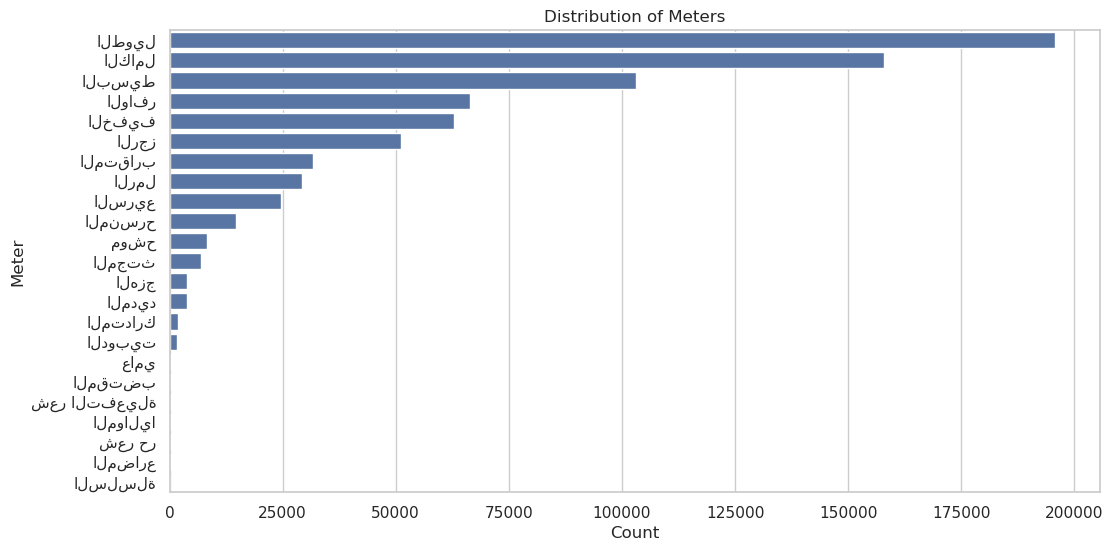

In [11]:
# Check distribution of meters
plt.figure(figsize=(12, 6))
sns.countplot(y='meter', data=processed_df, order=processed_df['meter'].value_counts().index)
plt.title('Distribution of Meters')
plt.xlabel('Count')
plt.ylabel('Meter')
plt.show()


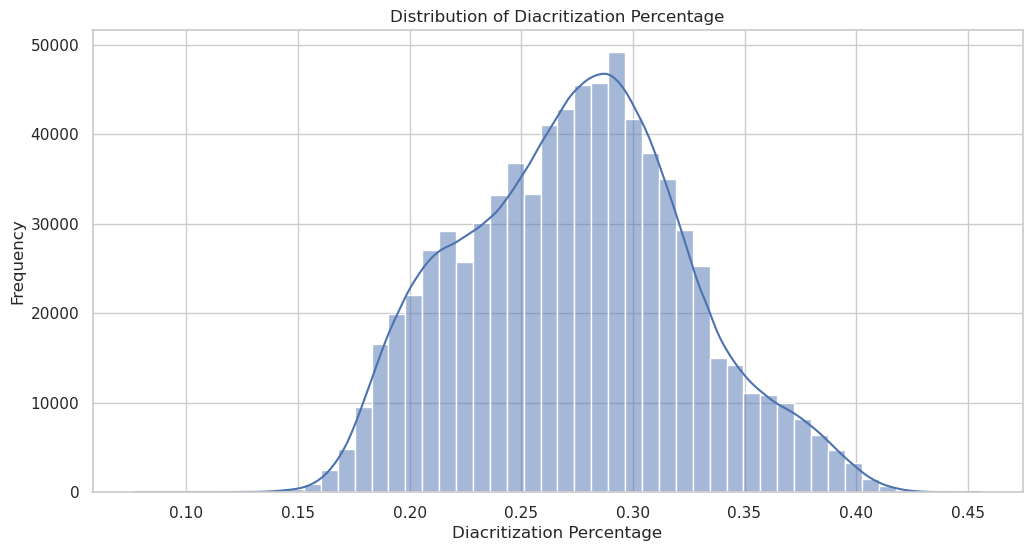

In [14]:
# Check diacritization percentage
diacritics_present = processed_df['text'].apply(lambda x: sum(1 for c in x if c in AR.tashkeel))
total_chars = processed_df['text'].apply(len)
percentage_diacritics = diacritics_present / total_chars

plt.figure(figsize=(12, 6))
sns.histplot(percentage_diacritics, bins=50, kde=True)
plt.title('Distribution of Diacritization Percentage')
plt.xlabel('Diacritization Percentage')
plt.ylabel('Frequency')
plt.show()


In [15]:
# Save processed data as CSV
print("Saving processed data...")
processed_df.to_csv(os.path.join(processed_output_dir, 'processed_data.csv'), index=False, encoding='utf-8-sig')
print(f"Processed data saved to {os.path.join(processed_output_dir, 'processed_data_0.3_only_tashkeel.csv')}")


Saving processed data...
Processed data saved to ../data/processed/processed_data_0.3_only_tashkeel.csv
